# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [76]:
import re
import os
import math
import json
import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from joblib import dump, load
import warnings
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
# Null values in the profile data
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [6]:
# Number of male, female and others
print(profile['gender'].value_counts())

M    8484
F    6129
O     212
Name: gender, dtype: int64


In [7]:
# Percentage of male, female and others
print(profile['gender'].value_counts()*100/profile.shape[0])

# Sum of percentages
sum(profile['gender'].value_counts()*100/profile.shape[0])

M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64


87.20588235294119

We can see that the above percentages do not add upto 100. Which indicates that there are some missing values in gender column

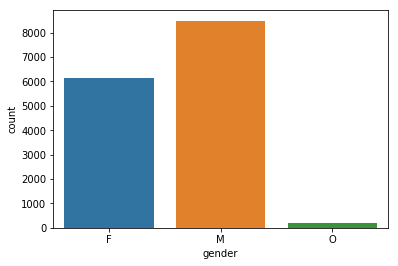

In [8]:
sns.countplot(profile['gender'])

In [9]:
def hist_plot(data, title, xlabel, ylabel):
    plt.hist(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

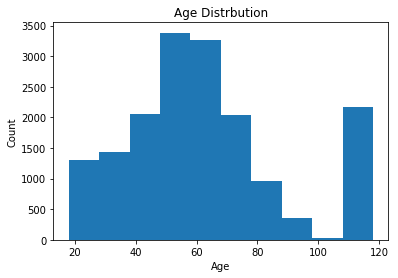

In [10]:
hist_plot(data=profile['age'], title='Age Distrbution', xlabel='Age', ylabel='Count')

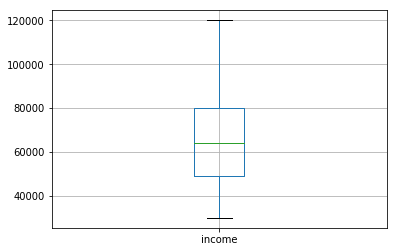

In [11]:
# Box plot for income
profile.boxplot('income')

In [12]:
profile[['gender','age']].groupby(['gender'], as_index = False).mean().sort_values(by='age',ascending=False)

,gender,age
0,F,57.544950
2,O,54.400943
1,M,52.116690


In [13]:
profile[['gender','income']].groupby(['gender'], as_index = False).mean().sort_values(by='income',ascending=False)

,gender,income
0,F,71306.412139
2,O,63287.735849
1,M,61194.601603


In [14]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

<Container object of 85 artists>

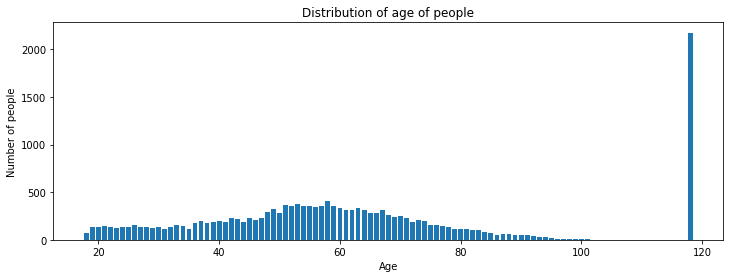

In [15]:
age_df = profile.groupby(['age'])['id'].count()
plt.figure(figsize=(12,4))
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.title('Distribution of age of people')

plt.bar(age_df.index, age_df)

In [9]:
profile[profile['age']== 118].age.count()

2175

According to the description of the profile data frame and checking null values, it looks like values of gender & income are missing where age is 118. To confirm, I'll print the values with age 118.

In [11]:
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1).head()

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN


In [12]:
#check for different age values
profile.age.value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

In [13]:
#check for age above 80 and less than 118 
profile[(profile['age'] > 80) & (profile['age'] < 118)].head()

,age,became_member_on,gender,id,income
33,96,20171117,F,868317b9be554cb18e50bc68484749a2,89000.0
94,89,20171114,F,4264b1d027cc493281bba4f44bfedaca,87000.0
98,90,20151210,F,1c587de019994f93a242c6864fd7bc55,98000.0
126,83,20180127,M,4c29d22467af4d7faa137c4eedd65340,46000.0
131,89,20180114,F,3dae0eadb47149b0b9b548d14548524b,65000.0


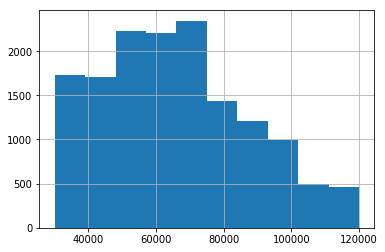

In [14]:
profile['income'].hist();

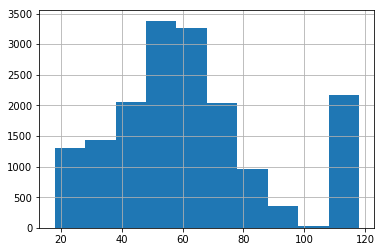

In [15]:
profile['age'].hist();

In [16]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')

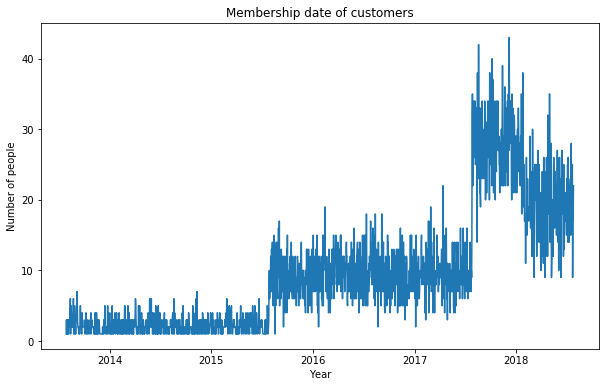

In [17]:
member_on_df = profile.groupby(['became_member_on'])['id'].count()
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Membership date of customers')

plt.plot(member_on_df)

We can see a substantial increase in the members in 2017 from the above graph

In [18]:
# Transcript data :
event_df = transcript['event'].value_counts()
event_df = pd.DataFrame(list(zip(event_df.index.values, event_df)),columns=['event', 'count'])
event_df

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [19]:
total_transactions = event_df['count'].sum()
percentage_transactions = 100 * event_df.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_df.iloc[1:]['count'].sum() / total_transactions
print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


In [20]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [21]:
profile['income'].mean()

65404.991568296799

In [22]:
profile['age'].mean()

62.531411764705879

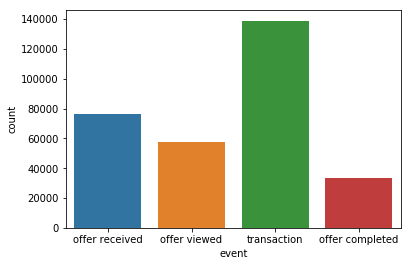

In [23]:
sns.countplot(transcript['event'])

## Data preparation
### Cleaning Portfolio


In [24]:
def rename_cols(df, new_cols_name):
    """
    Parameters
    ----------
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column
    
    Returns
    -------
    df: output data frame with renamed column names
       
    """

    df= df.rename(columns = new_cols_name)
    return df

In [25]:
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = rename_cols(portfolio, new_cols_name )

In [26]:
cleaned_portfolio.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [27]:
cleaned_portfolio.columns

Index(['channels', 'offer_difficulty', 'offer_duration', 'offer_id',
       'offer_type', 'offer_reward'],
      dtype='object')

In [28]:
def portfolio_cleaning(portfolio):
    '''
    Function to clean portfolio dataframe
    
    INPUT:
    portfolio - uncleaned portfolio dataframe
    
    OUTPUT:
    portfolio_cleaned_df - cleaned portfolio dataframe
    
    '''
   
    # apply one hot encoding to channels column
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # drop the channels and offer_type column
    portfolio.drop(['channels'], axis=1, inplace=True)
     
    return portfolio

In [29]:
portfolio_cleaned_df = portfolio_cleaning(portfolio)
portfolio_cleaned_df

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [30]:
profile.dtypes

age                          int64
became_member_on    datetime64[ns]
gender                      object
id                          object
income                     float64
dtype: object

### Cleaning Profile
* Renaming some columns for better readability & easiness in merging dataframes later.
* In order to not lose data with null values, it is better to impute them. So, I will consider imputing missing age & income values with mean and missing gender values with mode.
* Considering people with age above 80 as outliers, remove them from the dataset.
* Classifying ages into groups for better understanding in Exploratory Data Analysis later:

Under 20

20 - 45

46 - 60

61 - 80

In [31]:
#rename columns
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
cleaned_profile = rename_cols(profile, cols_profile )

In [32]:
cleaned_profile.columns

Index(['age', 'became_member_on', 'gender', 'customer_id', 'customer_income'], dtype='object')

In [33]:
def cleaning_profile(df):
    """
    Clean the profile data frame as per tasks 2-4
        
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per tasks
    """
    
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    df.replace(118, np.nan , inplace=True)
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    #replace missing gender values with mode i.e. most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df


In [34]:
cleaned_profile = cleaning_profile(cleaned_profile)

In [35]:
cleaned_profile.head()

,became_member_on,gender,customer_id,customer_income,Age_group
0,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,46-60
1,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,46-60
2,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,46-60
3,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,61-80
4,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,46-60


In [36]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
became_member_on    16014 non-null datetime64[ns]
gender              16014 non-null object
customer_id         16014 non-null object
customer_income     16014 non-null float64
Age_group           16014 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 750.7+ KB


In [37]:
# Rename columns
transcript_cols = {'person':'customer_id'}
cleaned_transcript = rename_cols(transcript, transcript_cols)

In [38]:
cleaned_transcript.columns

Index(['event', 'customer_id', 'time', 'value'], dtype='object')

In [39]:
def cleaning_transcript(df):
    """
    Cleaning the transcript data frame as per task 2.
    
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per task
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    #expand the dictionary to coulmns 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [40]:
cleaned_transcript = cleaning_transcript(cleaned_transcript)

In [41]:
cleaned_transcript.head()

,event,customer_id,time,offer_id,money_gained,money_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [42]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event           306534 non-null object
customer_id     306534 non-null object
time            306534 non-null int64
offer_id        306534 non-null object
money_gained    306534 non-null float64
money_spent     306534 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [43]:
# Finding unique types of values in "value" column (stored as a dict)
value_types = set()
for i in transcript.value:
    value_types.update(set(i.keys()))
value_types

{'amount', 'offer id', 'offer_id', 'reward'}

### Merging data frames

In [44]:
def merge_data(portfolio,profile,transcript):
    """
    Merge cleaned data frames for EDA
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [45]:
merged_df = merge_data(cleaned_portfolio, cleaned_profile, cleaned_transcript)

In [46]:
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,2017-09-09,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,2017-09-09,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,2017-09-09,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,2017-09-09,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,2017-09-09,M,100000.0,61-80


In [47]:
merged_df['customer_income'].mean()

65924.491099765321

In [60]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 15 columns):
channels            157503 non-null object
offer_difficulty    157503 non-null int64
offer_duration      157503 non-null int64
offer_id            157503 non-null object
offer_type          157503 non-null object
offer_reward        157503 non-null int64
event               157503 non-null object
customer_id         157503 non-null object
time                157503 non-null int64
money_gained        157503 non-null float64
money_spent         157503 non-null float64
became_member_on    157503 non-null datetime64[ns]
gender              157503 non-null object
customer_income     157503 non-null float64
Age_group           157503 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(7)
memory usage: 24.2+ MB


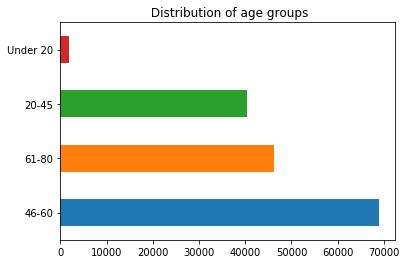

In [49]:
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of age groups')

* Encode categorical data such as gender, offer type, channel and age groups.
* Encode the 'event' data to numerical values:
* offer received ---> 1
* offer viewed ---> 2
* offer completed ---> 3
* Encode offer id and customer id.
* Drop column 'became_member_on' and add separate columns for month and year.
* Scale and normalize numerical data.

In [56]:

def cleaning_final_data(df):
    """
    Clean merged data frame for the final data as per tasks 1-5.
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical)
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column
   
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [58]:
cleaned_data = cleaning_final_data(merged_df)

In [59]:
cleaned_data.head(10)

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,0.5,0.571429,0,1.0,1,0,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,0.5,0.571429,0,1.0,2,0,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,0.5,0.571429,0,1.0,1,0,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,0.5,0.571429,0,1.0,2,0,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,0.5,0.571429,0,1.0,3,0,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
5,0.0,0.142857,1,0.0,1,0,0.571429,0.0,0.0,0.777778,...,0,0,1,0,1,1,0,1,9,2017
6,0.0,0.142857,1,0.0,2,0,0.655462,0.0,0.0,0.777778,...,0,0,1,0,1,1,0,1,9,2017
7,1.0,1.000000,2,0.5,1,0,0.235294,0.0,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017
8,1.0,1.000000,2,0.5,2,0,0.243697,0.0,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017
9,1.0,1.000000,2,0.5,3,0,0.252101,0.5,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017


In [61]:
cleaned_data.columns

Index(['offer_difficulty', 'offer_duration', 'offer_id', 'offer_reward',
       'event', 'customer_id', 'time', 'money_gained', 'money_spent',
       'customer_income', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'gender_F', 'gender_M', 'gender_O',
       'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'email', 'mobile', 'social', 'web',
       'month_member', 'year_member'],
      dtype='object')

### Train and test data
Final data is ready after tasks 1-5. We will now split the data (both features and their labels) into training and test sets, taking 60% of data for training and 40% for testing.

In [62]:
data = cleaned_data.drop('event', axis=1)
label = cleaned_data['event']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 94501 rows
Testing set: 63002 rows


### Metrics
We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [71]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

### NeighborsClassifier
We use the K-Nearest Neighbors algorithm to build the benchmark, and evaluate the model result by the F1 score metric.

In [72]:
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [73]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)

In [74]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,54.346515,32.891019


### RandomForestClassifier

In [77]:
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

### DecisionTreeClassifier

In [78]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

### Conclusions

The males represent 62.7% of the data and use the Starbucks app more than the females. Specifically, both males & females in the age group 46-60 use app the most. Discount offers are more preferred by the customers. Also, there are less number of customers who actually complete the offer as compared to the ones who just view & ignore it. We can look more to the figures & information in section- iii) Exploratory Data Analysis (points 1-10) to best determine which kind of offers to send to the customers.

In [81]:
plot_gender = merged_df[merged_df['gender'] != 'O']

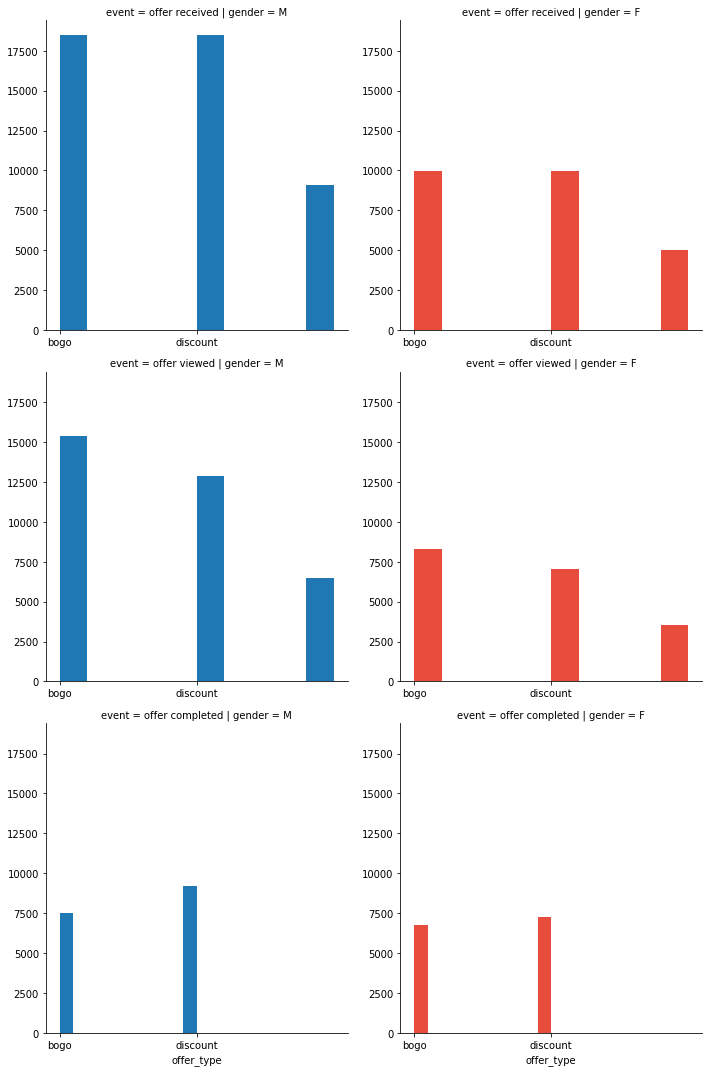

In [82]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(plot_gender, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

### Model comparisons & evaluation against the model metric

In [83]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)

In [84]:
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),54.346515,32.891019
1,RandomForestClassifier,94.336568,69.304149
2,DecisionTreeClassifier,95.455075,85.098886


The validation set (test data set) is used to evaluate the model. Both the models are better than the benchmark. The best score is created by the DecisionTreeClassifier model, as its validate F1 score is 85.10, which is much higher than the benchmark. The RandomForestClassifier model scores good as well compared to the benchmark, with a test F1 score of 69.30. Our problem to solve is not that sensitive which requires very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.